<center><font size="6">Хакатон от Моторики</font>

[Второй этап](https://www.kaggle.com/competitions/motorica-continuous-command-classification/)

Команда 1.

# Условие задачи, загрузка и описание данных 

Компания М. заниимается разработкой механизированных протезов для рук. В ходе проектирования системы передачи движения протеза от человека к протезу была выявлена необходимость определения жеста кисти по показаниям датчиков оптомиографии поверхности кожи человека. Поскольку необходимые данные для построения модели невозможно собрать у человека без руки, в сборе данных участвовал здоровый человек. 

Эксперимент по сбору данных был организован следующим образом: выбран ряд характерных жестов, который может совершать человек со здоровой кистью. Жесты из этого набора передавались на механическую кисть-протез. Оператор (человек) повторял жесты, которые ему показывала механическая кисть-манипулятор. По условиям эксперимента исходное либо конечное состояние кисти - жест "открытая ладонь". 

Поскольку оператор тратил некторое время на принятие решения о выполнении жеста, то его жесты выполнялись с некоторой задержкой относительно механической кисти. Сигналы манипулятора были записаны файл y_train, а сигналы с датчиков оптомиографии были записаны в файлы X_train и X_test. 

# Задача: 
Построить классификационную модель, которая будет определять класс жеста и время начала выполнения жеста по показаниям датчиков оптомиографии.

Файлы:
* X_train.npy - обучающая выборка, имеющая размерности "наблюдения, датчики, время"
* X_test.npy - тестоваая выборка, имеющая размерности "наблюдения, датчики, время"
* y_train.npy - маска выполнения жеста для обучающей выборки, которая имеет размерность  (наблюдения * время) и содержит следующие классы:

| Номер <br> класса | Описание жеста |
| :---: | :--- |
| "0"  |  жест "open" <br> *обозначает возвращение руки в состояние "раскрытая ладонь"* |
| "1"  |  сгиб мизинца |
| "2"  |  сгиб безымянного пальца |
| "3"  |  сгиб среднего пальца |
| "4"  |  сгиб жеста "пистолет" |
| "5"  |  сгиб указательного пальца |
| "6"  |  сгиб большого пальца |
| "7"  |  жест "ok" |
| "8"  |  жест "grab" <br> *означает схват* |

Временной промежуток составляет от 0 до 99 единиц.

# Import библиотек и описание функций

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np

# графические библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# библиотеки машинного обучения
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras import backend as K
#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# отображать по умолчанию длину Датафрейма
pd.set_option("display.max_rows", 15, "display.max_columns", 9)  #9

# библиотека взаимодействия с интерпретатором
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
import os

### Подготовка данных

In [2]:
# проверяем все ли правильно
PATH = './'
print(os.listdir(PATH))

['.git', '1_Motorica_sprint2.ipynb', '2_1_Log model.ipynb', '3_0_NN_lstm.ipynb', 'best_models', 'figures', 'Motorica_2.py', 'predict_proba 5080 3565i11 02s2_ch.xlsx', 'README.md', 'sample_submission.csv', 'X_test.npy', 'X_train.npy', 'y_test_2rnn_sigmoid_predicted.csv', 'y_train.csv', 'y_train_gb_ge.csv', 'y_train_upd.csv', '__init__.py', '__pycache__']


In [3]:
# библиотека вызова функций
import Motorica_2 as m

Пропущенные значения в файле у_train отсутствуют. В графе "timestep" указано, что измерения проходили за 100 временных единиц. Перегруппируем данные в таблицу так, чтобы графами были временные промежутки, а значениями были индексы класса. Значения в графах представляют собой некоторый вектор класса в соответствующий момент времени.

Для удобства адресации к массиву представим его в трехмерном виде.

Добавим возможность вывести индексы наблюдений.

# Решение

Проанализируем произвольно взятый жест 0-1 "сгиб мизинца" и найдём номера его наблюдений.

In [4]:
samples = m.get_test_id('0-1')

Наблюдения жеста 0-1: [10, 28, 46, 64, 82, 100, 118, 136, 154, 172, 190, 208, 226, 244, 262, 280, 298, 316]


Выберем произвольно наблюдение 10 и отобразим показания датчиков во времени.

In [5]:
m.get_all_sensors_plot(10, plot_counter=1)

<center> <img src = "./figures/fig_1.png"> </center>

На рис.1 изображена диаграмма сигналов датчиков. Отметим, что датчики можно разделить по средней величине сигнала на 2 группы:
* активные (0, 2, 5, 8, 12, 15, 17, 19, 21, 24, 27, 29, 30, 33, 36, 38). Их средняя величина превышает 200;
* спящие (все остальные), средняя величина менее 200.

Сравним время изменения показаний датчиков с временем изменения класса жеста.

In [6]:
m.get_gest_plot(10, plot_counter=2)

<center> <img src = "figures/fig_2.png"> </center>

На рис.2 изображена диаграмма изменения класса жеста, на которой скачок изменения наблюдается в районе 50 временного промежутка. Сравнивая рис.2 с диаграммой сигналов датчиков (рис.1) мы видим, что на первой реакция датчиков происходит с запаздыванием (примерно на 70 временном интервале). 
Как видно из рис.2, в наблюдении 10 был совершен жест 1.

Отфильтруем активные и пассивные датчики.

In [7]:
m.get_active_passive_sensors_plot(10, plot_counter = 3)

<center> <img src = "figures/fig_3.png"> </center>

На Рис.3 слева представлены показания активных датчиков наблюдения 10, а справа - пассивных датчиков. Рассматривая динамику показаний активных датчиков во времени условно отметим 3 периода:

* 0 - 59 с. - "покой" и слабое изменение;
* 60 - 79 с. - "значительное изменение уровня" сигнала при выполнении жесте;
* 80 - 99 с. - "стабилизаця" после движения. 

Показания пассивных датчиков колеблются с низкой амплитудой по сравнению с амплитудой колебания активных датчиков. Изучим амплитуды сигналов.

### Амплитуды сигналов датчиков

In [8]:
m.get_amplitude(10, plot_counter = 4)

<center> <img src = "figures/fig_4.png"> </center>

Распределение ампитуд по группам представлено на рис.4. Анализируя гистограмму можно сгруппировать датчики по величине амплитуды на 2 группы: 

| Абсолютная <br> амплитуда | группа датчиков |
| :--: | :-- |
| < 200 | слабые |
| > 200 | сильные |

Затем отобразим показания обеих групп датчиков раздельно.

In [9]:
m.get_strong_weak_sensors_plot(10, plot_counter = 5)

 
Датчики с большой амплитудой, наблюдение 10:  [0, 2, 5, 8, 12, 15, 17, 19, 24, 27, 29, 30]
Датчики с малой амплитудой, наблюдение 10:  [21, 33, 36, 38]


<center> <img src = "figures/fig_5.png"> </center>

На рис. 5 слева сигналы "сильные" датчиков, справа - "слабые". Отметим характерный скачок амплитуды у сильных датчиков в районе 70 временного интервала и практически плавное изменение амплитуды у слабых датчиков. Индексы датчиков по группам:
* сильные: [0, 2, 5, 8, 12, 15, 17, 19, 24, 27, 29, 30]
* слабые:  [21, 33, 36, 38]

Анализируя графики можно сказать, что датчики с сильными сигналами лучше реагируют на изменение класса жеста. Однако, датчики реагируют на движение с небольшим запаздыванием и разной амплитудой.

Проверим как реагируют сенсоры в рамках произвольно выбранного жеста.

Выберем жест "0-1" и сравним сигналы 2 сильных датчиков и 2 слабых.

In [10]:
m.get_sensors_in_all_tests_plot('0-1', [24, 27, 33, 36], plot_counter=6)

Наблюдения жеста 0-1: [10, 28, 46, 64, 82, 100, 118, 136, 154, 172, 190, 208, 226, 244, 262, 280, 298, 316]


<center> <img src = "figures/fig_6.png"> </center>

На рис.6 предствлены показания "сильных" датчиков 24,27 и "слабых" 33,36.
Отметим, что сигнал датчиков изменяется c разной амплитудой и запаздыванием во всех наблюдениях.

При снятии показаний датчиков в режиме реального времени текущие показания необходимо сравнивать с полученными ранее. Однако, по условию задания такого ограничения нет. Поэтому произвольно выберем датчик 2. Построим по 2 блочные диаграммы для начала и конца временного промежутка каждого жеста по всем наблюдениям: 
* [:50] - от нулевого временного промежутка до начала движения (красного цвета);
* [80:] - после окончания жеста до конечного временного промежутка (синего цвета).

Блочные диаграммы для остальных датчиков вынесены в файл analys_boxplot_abs.ipynb чтобы не загромождать настоящий файл

In [11]:
import __init__
X_train = __init__.X_train
y_train = __init__.y_train
df = m.read_gests(X_train, y_train, 50, 80)
m.box_sens(2, df[df['b_e'] != 'pass'].loc[:, ['sensor_2', 'b_e', 'Class_name']], plot_counter=7)

<center> <img src = "figures/fig_7.png"> </center>


На рис. 7 можно выделить характерные уровни показаний для разных жестов:
- "open" в диапазоне от 1000 до 1300, 
- сгиб среднего пальца - более 2500, 
- сгиб безымянного пальца - менее 900.

Сравнивая распределения данных жестов сгиб большого пальца" и "open" отметим, что они пересекаются. Это означает, что не возможно различить эти жесты исключительно по показаниям данного датчика. С другой стороны, абсолютные показания даннного датчика указывают на жест "сгиб среднего пальца". На основании этого факта сделаем индуктивное предположение:

# Гипотеза №1
---
Допустим, что все жесты можно достоверно дифференцировать по абсолютным показаниям нескольких датчиков. Для классификации жестов используем модель логистической регрессии, полученную на первом этапе поскольку она должна достаточно
хорошо работать как на перепадах средних показаний датчиков, так и на абсолютных 
показаниях, взятых для наблюдения в момент времени t.

То есть разбиваем решение задачи на два этапа:
- обучаем модель первого этапа для классификации жеста в каждый момент времени t на данных
начала и окончания каждого наблюдения (в те моменты времени, когда имеем для обучения "чистый"
жест),
- используем обученную модель для каждого последовательного момента времени в наблюдении из X_test. Считаем, 
что время t, когда наша модель перестала однозначно идентифицировать жест "начала" наблюдения и стала показывать возможность реализации другого - это и есть искомое время совершения жеста.


## Предобработка данных и построение модели 

Предобработка данных и построение модели логистической регрессии приводится в файле 2_1_Log model.ipynb


## Результаты работы модели и категоризации данных

Посмотрим на полученные результаты.
На рисунке ниже видим часть выгрузки вероятностей, полученной в ходе постобработки результатов работы обученной модели на X_test. Не смотря на то что модель упорно считает переход из "0" в "8" жест выполненным через несколько
"4"-х жестов, "момент" выхода из "0" жеста определяется достаточно четко. Возможно, такое "плавание" при классификации жестов связано
с фактическим исполнением жеста пилотом в этом наблюдении.

<center> <img src = "figures/sample_372__gesture_08.png" width="800" height="550" > </center>

В результате валидации модели на тестовой выборке нами были получены удовлетворительный f-score, равный 0,97407 для количества интервалов, равного 5, 7, 9, 11. Улучшение скора между 9 и 11 
интервалами составило на Public  0,97407 - 0,9737 = 0,00037. Т.е. один временной тик на одном наблюдении.

По нашему мнению, достаточно хорошее предсказание можно получить при выделении 7-ми категориальных интервалов.

"Достаточно хорошее предсказание" означает следующее. Для определения качества работы модели организаторами предоставлен только один критерий - соответствие таргету на kaggle, соответственно, ориентируемся на доступный критерий. Между скорами 0,97407 и 1 разница составляет 0,02593. Разделим эту разницу на 0,00037 - скор на Public за улучшение ответа на 1 тик (1 / 5400 * 2 ). Получаем 70 точек, умножаем
на 2, чтобы учесть закрытую часть. Итого, наша ошибка составляет порядка 140 точек на 48 
наблюдениях (еще 6 - жесты "0-0", в них нельзя ошибиться с моментом перехода). В ходе работы с данными
мы понимаем, что "недоопределенные" точки более-менее равномерно распределены по всем наблюдениям. Это по 
3-4 тика "неточности" в определении достаточно абстрактного понятия "момента" на плавном изменении
датчиков при совершении движения. Думаем, что дальнейшее увеличение точности модели не имеет 
практической ценности.

# Гипотеза №2
---

Если обучать модель на данных *X_train*, а также *y_train* без дополнительного преобразования, то предсказание модели на тестовой выборке *X_test* будет очень плохим. В результате обучения модели нами было получено значение f1-score на тестовой выборке около 1, а на валидационной выборке - значение 0.77481. Таким образом, для достижения удовлетворительной точности определения начала выполнения жеста необходима предварительная обработка данных *y_train*. Далее будет кратко описан проведенный разведочный анализ.


Для фиксации момента начала роста сигнала датчиков рассмотрим поведение первой производной (np.diff c n=1).

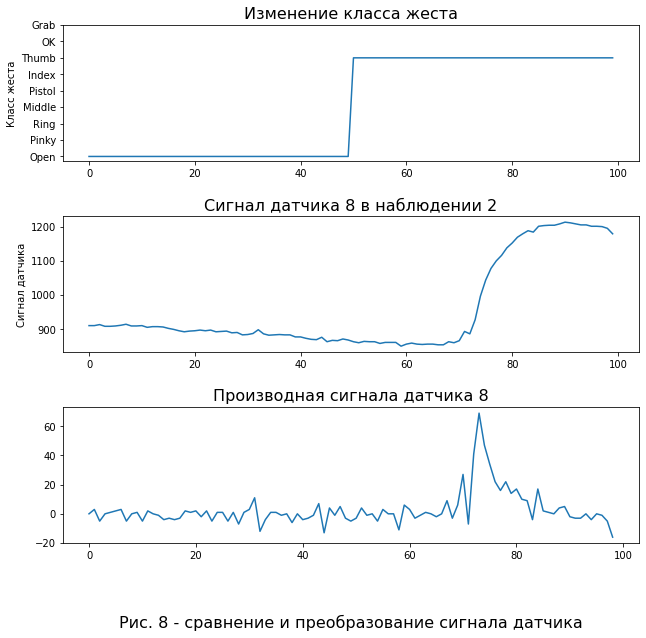

In [12]:
# Анализируем датчик 8 для рассматриваемого наблюдения 2
m.get_diff_plot(2, 8 , plot_counter=8)

На рис.8 видно, что уровень сигнала датчика на временном интервале от 0 до 50 падает, хотя на данном промежутке времени жест зафиксирован. Такое поведение датчиков встречается во многих наблюдениях, что добавляет шум к временной зависимости первой производной и момент роста сигнала датчиков при выполнении жеста можно пропустить либо зафиксировать позже (при выставлении большого порога фиксации первой производной). Было решено искать другие возможности фиксации роста уровней сигналов датчиков.  

Следующей идеей была попытка зафиксировать рост уровня сигналов датчиков с помощью скользящих средних с разными таймфреймами. Две скользящие средние с разными таймфреймами в момент роста сигнала будут пересекаться, можно зафиксировать и интерпретировать, как начало выполнения жеста (Аналог MACD-индикатор в финансовом техническом анализе).  

Преобразование сигнала

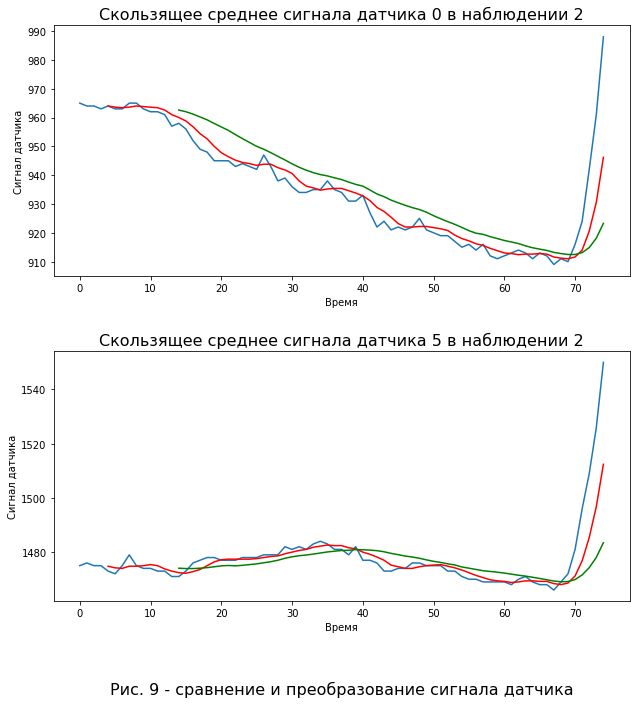

In [13]:
m.get_roling(2, [0, 5], plot_counter=9)

<center> <img src = "figures/fig_9.png"> </center> 

Анализируя рис.9 отметим, что на нижнем графике имеется нескольколько пересечений кривых. В связи со сложностью обработки таких данных было решено отказаться от использования скользящих средних и попробовать следующую идею: расчет среднеквадратичных отклонений для скользящего окна.  
Исходя из определения среднеквадратичного отклонения в случае, если в рассматриваемом окне произойдет скачкообразное изменение величины сигналов, то среднеквадратическое отклонение возрастёт также скачкообразно.

Дальнейшие преобразования данных представлены в файле 3_0_NN_LSTM.ipynb.